In [ ]:
# Download the data from kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

!unzip /content/chest-xray-pneumonia.zip -d /content/chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Get the data from the local source and store it in train, test, val varibales
labels = ["NORMAL", "PNEUMONIA"]
img_size = 128
def get_data(dir):
  data = []
  for label in labels:
    path = os.path.join(dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        if img_arr is None:
          continue
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, class_num])

      except Exception as e:
        print(f"Some Error in processing {img} : {e}")
  return data


In [ ]:
train = get_data("/content/chest-xray-pneumonia/chest_xray/train")
test = get_data("/content/chest-xray-pneumonia/chest_xray/test")
val = get_data("/content/chest-xray-pneumonia/chest_xray/val")

In [ ]:
len(train), len(test), len(val)

(5216, 624, 16)

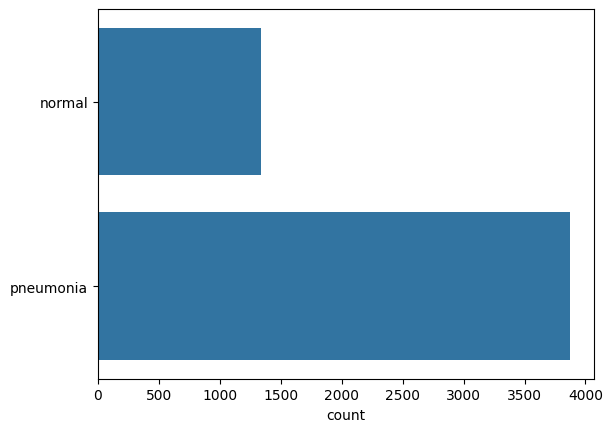

In [ ]:
count_list = []
for img in train:
  if img[1]==0:
    count_list.append("normal")
  else:
    count_list.append("pneumonia")

sns.countplot(count_list)
plt.show()

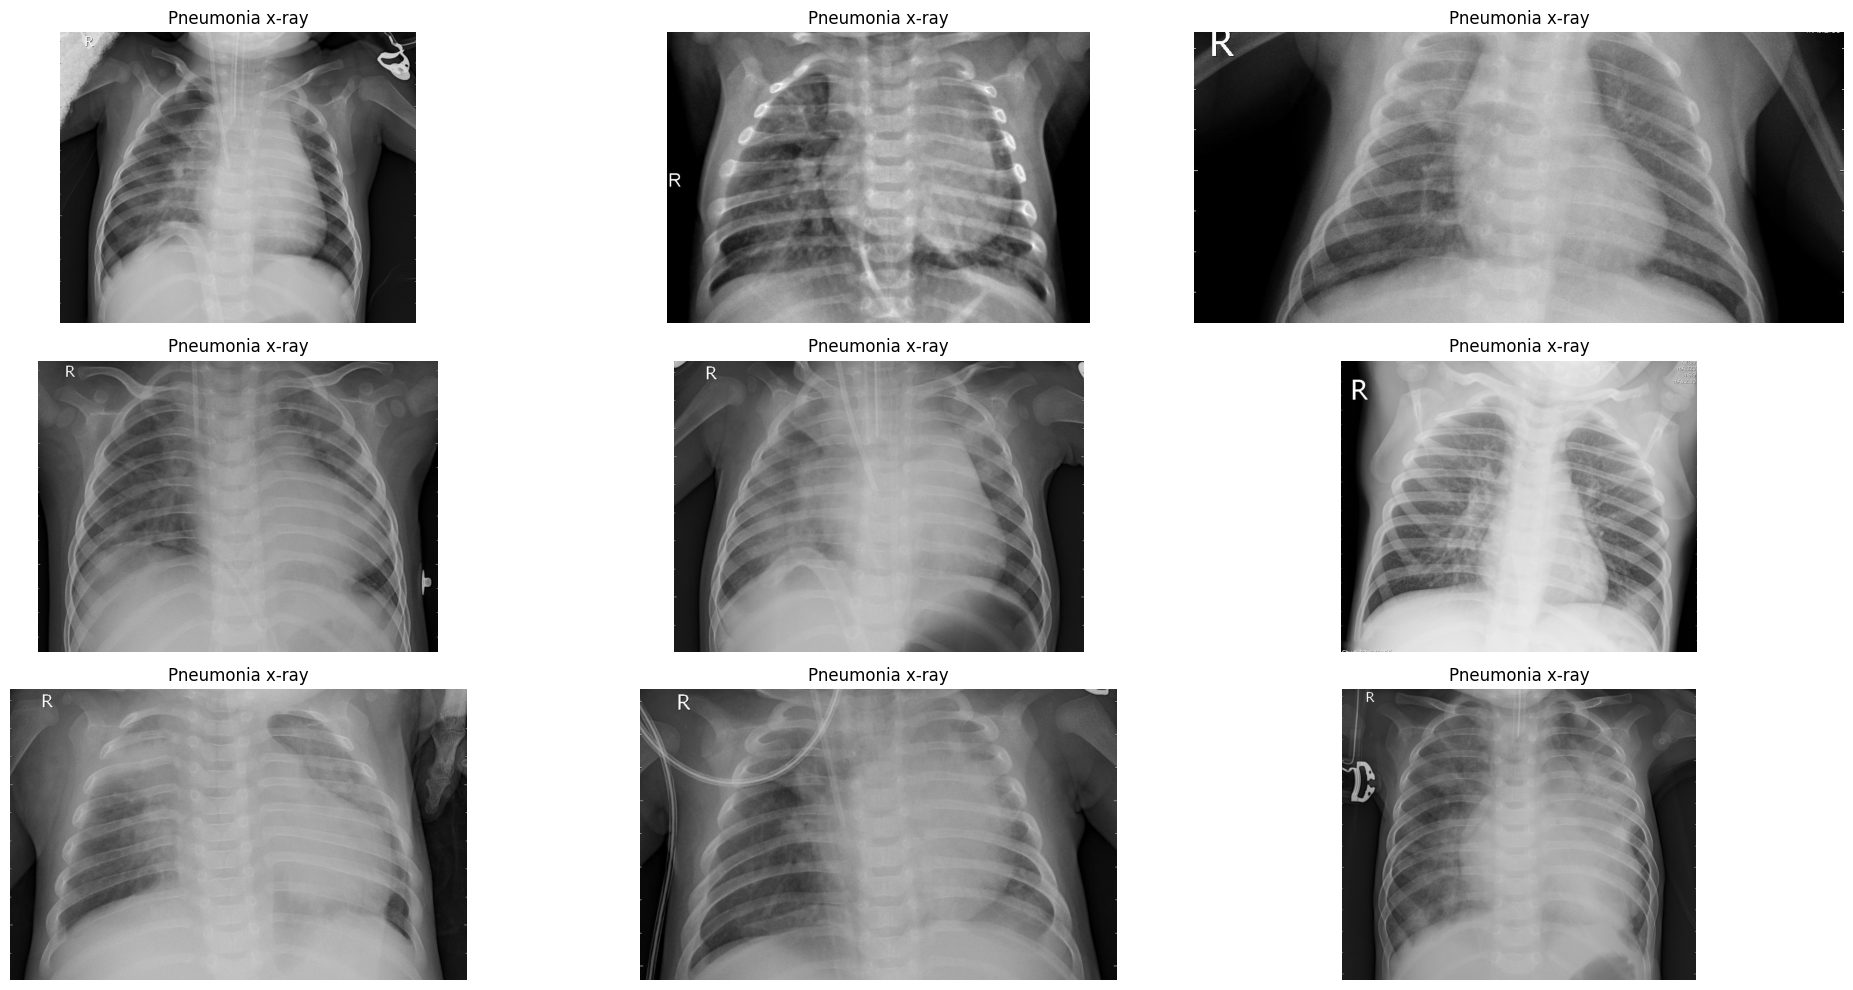

In [ ]:
# visualize the Pneumonia x-rays

pneumonia = "/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"

plt.figure(figsize=(20, 10))
for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(pneumonia, os.listdir(pneumonia)[i]))
  plt.imshow(img, cmap="grey")
  plt.axis("off")
  plt.title("Pneumonia x-ray")
plt.tight_layout()

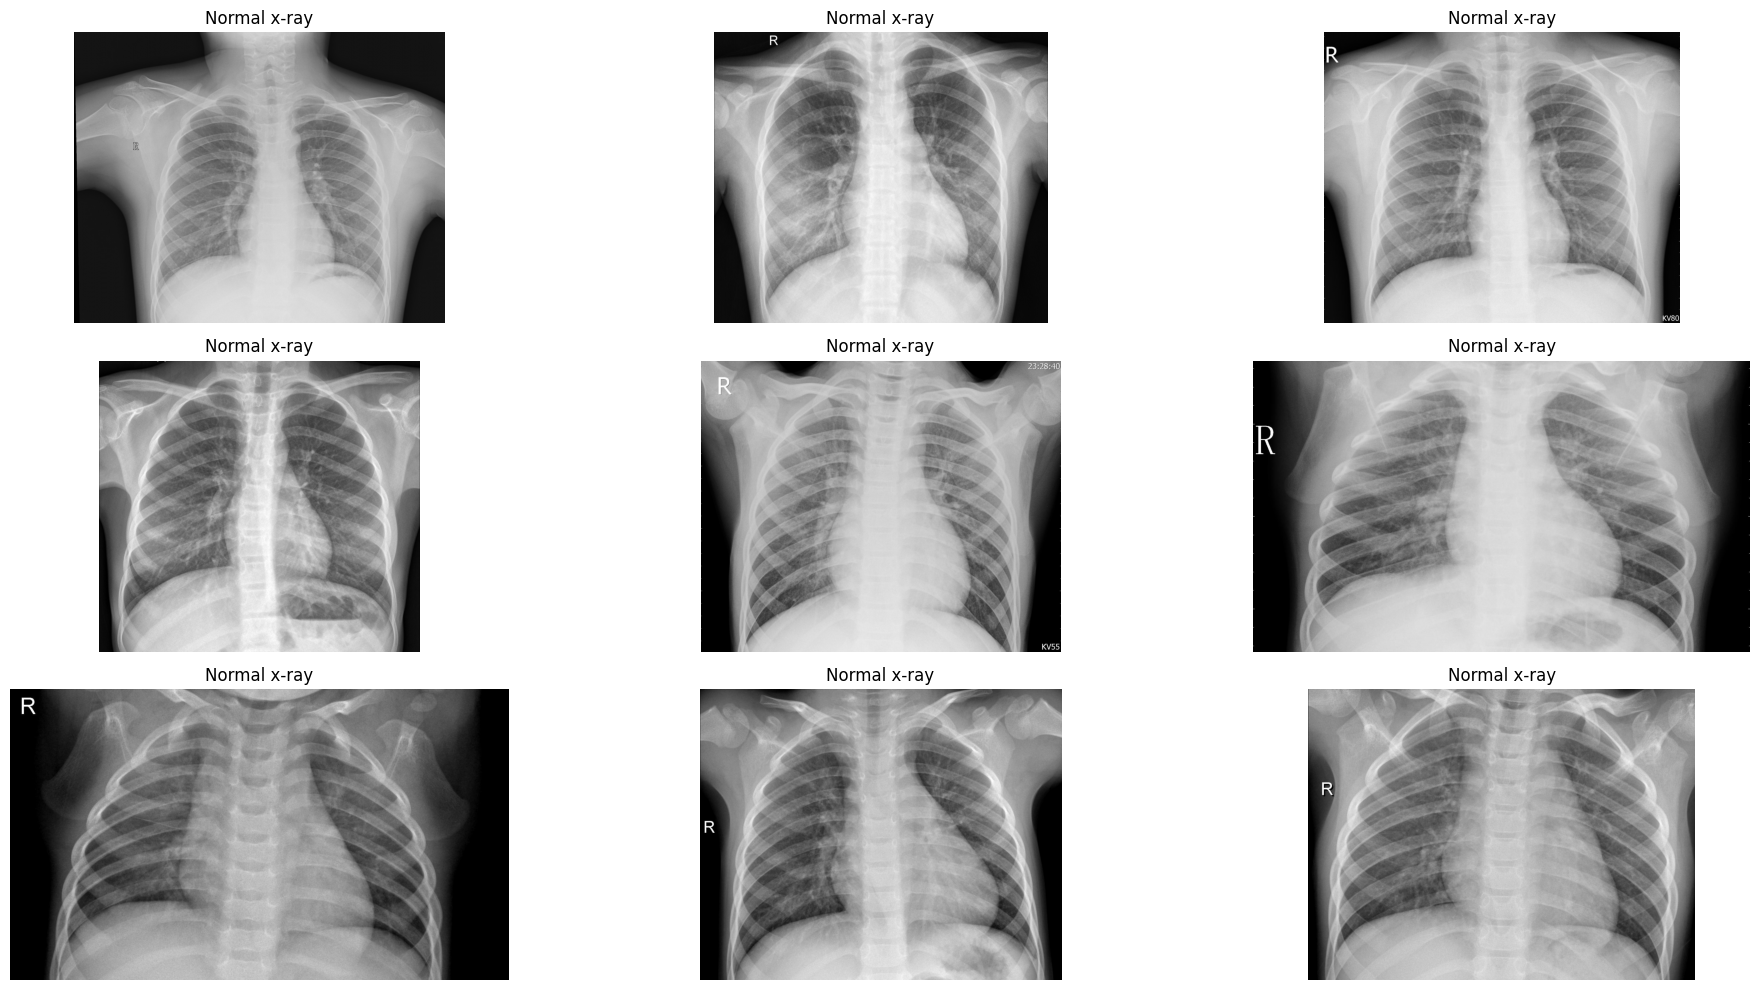

In [ ]:
# visualize the Normal x-rays

normal = "/content/chest-xray-pneumonia/chest_xray/test/NORMAL"

plt.figure(figsize=(20, 10))
for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(normal, os.listdir(normal)[i]))
  plt.imshow(img, cmap="grey")
  plt.axis("off")
  plt.title("Normal x-ray")
plt.tight_layout()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# we are normalizing the image data and also adding some variations in the training data to avoid overfitting.

# Generators
train_gen = ImageDataGenerator(rescale=1/255,
                               horizontal_flip = 0.4,
                                   vertical_flip = 0.4,
                                   rotation_range = 40,
                                   shear_range = 0.4,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode = "nearest")

test_gen = ImageDataGenerator(rescale=1/255)
val_gen = ImageDataGenerator(rescale=1/255)


# Transformation
train_data = train_gen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/train",
                                          batch_size=32,
                                          target_size=(128, 128),
                                          shuffle=True,
                                          class_mode='categorical',
                                          seed=42,
                                          color_mode='rgb')
test_data = train_gen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/test",
                                          batch_size=32,
                                          target_size=(128, 128),
                                          shuffle=True,
                                          class_mode='categorical',
                                          seed=42,
                                          color_mode='rgb')
val_data = train_gen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/val",
                                          batch_size=32,
                                          target_size=(128, 128),
                                          shuffle=True,
                                          class_mode='categorical',
                                          seed=42,
                                          color_mode='rgb')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
val_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# VGG 19 CNN architecture

base_model = VGG19(input_shape=(128,128,3), include_top=False, weights='imagenet')

for layers in base_model.layers:
  layers.trainable=False

x = base_model.output
flattened = Flatten()(x)
layer_1 = Dense(512, activation='relu')(flattened)
dropout = Dropout(0.3)(layer_1)
layer_2 = Dense(256, activation='relu')(dropout)
dropout = Dropout(0.2)(layer_2)
layer_3 = Dense(128, activation='relu')(dropout)
dropout = Dropout(0.2)(layer_3)
output = Dense(2, activation='softmax')(dropout)

model = Model(base_model.inputs, output)
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             

 Total params: 24,383,682 (93.02 MB)

 Trainable params: 4,359,298 (16.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# some hyperparameters which helps in training the model well without overfitting.
file_path = 'model.keras'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True, save_weights_only=False, save_freq='epoch')
reduce_plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, min_lr=1e-6, patience=3, verbose=1)
adam = Adam(learning_rate=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(
                          train_data,
                          epochs=10,
                          steps_per_epoch=50,
                          callbacks=[early_stopping, checkpoint, reduce_plateau],
                          validation_data = val_data
                          )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 508ms/step - accuracy: 0.7137 - loss: 0.5734 - val_accuracy: 0.5625 - val_loss: 0.9401 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - accuracy: 0.7966 - loss: 0.4124 - val_accuracy: 0.6875 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - accuracy: 0.8440 - loss: 0.3672 - val_accuracy: 0.5625 - val_loss: 0.8558 - learning_rate: 1.0000e-04
Epoch 4/10
13/50 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - accuracy: 0.8592 - loss: 0.3343

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8460 - loss: 0.3334 - val_accuracy: 0.8125 - val_loss: 0.5553 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.8219 - loss: 0.3793 - val_accuracy: 0.7500 - val_loss: 0.9513 - learning_rate: 1.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.8514 - loss: 0.3258 - val_accuracy: 0.7500 - val_loss: 0.8404 - learning_rate: 1.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8707 - loss: 0.3102
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - accuracy: 0.8705 - loss: 0.3103 - val_accuracy: 0.6250 - val_loss: 0.8743 - learning_rate: 1.0000e-04
Epoch 7: early stopping


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def get_test_img_array(img_path):
  img = image.load_img(img_path, target_size=(128,128))
  img_arr = image.img_to_array(img)
  img_arr = img_arr/255.0
  img_arr = np.expand_dims(img_arr, axis=0)
  return img_arr

In [ ]:
img1 = "/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
img2 = "/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
img3 = "/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person155_bacteria_729.jpeg"
img4 = "/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0009-0001.jpeg"
img5 = "/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0025-0001.jpeg"
images = [img1, img2, img3, img4, img5]

for img in images:
  img_arr = get_test_img_array(img)
  print(model.predict(img_arr))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.8138835  0.18611652]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.23883338 0.76116663]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.01720784 0.9827922 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.7474682 0.2525319]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.7608347 0.2391653]]


In [ ]:
best_saved_model = load_model('model.keras')
for img in images:
  img_arr = get_test_img_array(img)
  print(best_saved_model.predict(img_arr))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
[[0.8868697  0.11313024]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.48564684 0.51435316]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.076047 0.923953]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.78621835 0.21378164]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.8560646  0.14393535]]


In [ ]:
# evaluating on test data
model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8028 - loss: 0.4297


[0.438965380191803, 0.8044871687889099]

In [ ]:
best_saved_model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.7911 - loss: 0.4720


[0.45888280868530273, 0.7932692170143127]

In [ ]:
# evaluating on validation_data
model.evaluate(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6250 - loss: 1.0458


[1.0457862615585327, 0.625]

In [ ]:
best_saved_model.evaluate(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6250 - loss: 0.7918


[0.7917934060096741, 0.625]

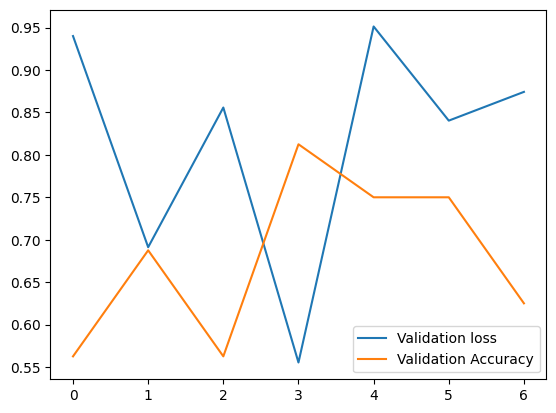

In [ ]:
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

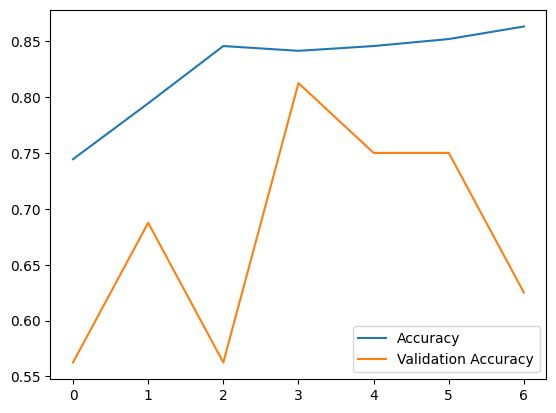

In [ ]:
plt.plot(model_history.history['accuracy'], label='Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()